# Assignment 3

1. Implement Logistic Regression with Stochastic Gradient Decent using numpy
1. Implement Logistic Regression with early stopping using pytorch

Additional readings:
1. https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html
1. https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# retrieve dataset
data = fetch_20newsgroups()


X_train = data['data']
y_train = data['target']

tfidf = TfidfVectorizer(max_df=0.5, min_df=10)
X_train = tfidf.fit_transform(X_train)

test_data = fetch_20newsgroups(subset='test')
X_test = tfidf.transform(test_data['data'])
y_test = test_data['target']

## 1 Binary Logistic Regression
$\{(x_i, y_i)\}_{i=1}^N$, $y \in \{0,1\}$
$$ z = Xw + b $$

$$p(y=1 | x) = \sigma(z) = \frac 1 {1 + e^{-z}}$$

$$ L_{batch} = - \frac 1 {|batch|} \sum_{i \in batch}^N [ y_i \log \sigma(z_i) + (1 - y_i) \log (1 - \sigma(z_i)) ] + \frac \lambda 2 w^T w$$

Stochastic Gradient Decent for logreg:
1. init w ~ random N(0,1), b = 0
1. for epoch = 1..n_epochs:
    * shuffle dataset
    * for every batch:
        * $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L_{batch}(w^{(t-1)},b^{(t-1)})$
        * $b^{(t)} \leftarrow b^{(t-1)} - \alpha \nabla_{b} L_{batch}(w^{(t-1)},b^{(t-1)})$
        
$w$ - weights  
$b$ - biases  
$\alpha$ - learning rate

Hint:
$$\nabla_w L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial w} + \frac {\partial (\frac \lambda 2 w^T w)} {\partial w} $$
$$\nabla_b L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial b} $$

In [2]:
# make dataset for binary classification

X_train_bin = X_train[y_train < 2]
y_train_bin = y_train[y_train < 2]

X_test_bin = X_test[y_test < 2]
y_test_bin = y_test[y_test < 2]

y_train_bin.shape, y_test_bin.shape

((1064,), (708,))

auc 0.9963816876324633


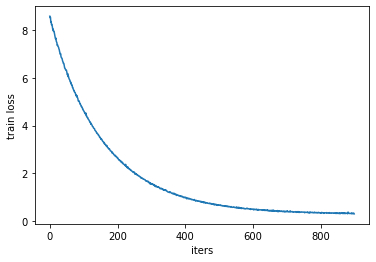

In [3]:
class LogRegNumpy(ClassifierMixin):
    def __init__(self, llambda=1, lr=0.1, batch_size=32, n_epochs=100):
        """
        llambda: regularization strength
        lr: learning rate
        """
        self.w = None
        self.b = 0
        self.llambda = llambda
        self.n_epochs = n_epochs
        self.lr = lr
        self.history = []
        self.batch_size = batch_size
        
    def fit(self, X, y):
        self.w = np.random.randn(X.shape[1])
        self.b = 0
        
        for epoch in range(self.n_epochs):
            
            # random permutation over indices of dataset
            batch_indices = np.random.permutation(len(y))
            
            for j in range(0, len(y), self.batch_size):
                batch_idx = batch_indices[j:j+self.batch_size]
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]
            
                # forward pass
                # <TODO> [1 point] calculate batch loss
                z = batch_X.dot(self.w) + self.b
                h = 1/(1+np.exp(-z))
                loss = -1 * np.mean(batch_y * np.log(h) + (1 - batch_y) * \
                                    np.log(1 - h)) + (self.llambda / 2) * \
                                    self.w.T.dot(self.w)

                # backward pass
                # <TODO> [2 points] calculate batch gradients 
                grad_w = batch_X.T.dot((h - batch_y)) / self.batch_size + \
                         self.llambda * self.w
                grad_b = np.sum(h - batch_y) / self.batch_size

                # SGD optimization step
                # <TODO> [1 point]
                self.w -= self.lr * grad_w
                self.b -= self.lr * grad_b
                
                self.history.append(loss)
        
        return self 
    
    def predict_proba(self, X):
        # <TODO> [1 point] calculate p(y=1 | x)
        z = X.dot(self.w) + self.b
        p = 1/(1+np.exp(-z))
        return p
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)
    
    
model = LogRegNumpy(llambda = 0.001, lr=3, batch_size=128, n_epochs=100)
model.fit(X_train_bin, y_train_bin)
print('auc', metrics.roc_auc_score(y_test_bin, model.predict_proba(X_test_bin)))

plt.plot(np.arange(len(model.history)), model.history)
plt.xlabel('iters')
plt.ylabel('train loss');

# Multinomial Logistic Regression using pytorch

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

###  [1 point] implement linear model $Z = XW + b$

In [0]:
class LogRegNN(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogRegNN, self).__init__()
        
        # create tensor of weights and tensor of biases
        # initialize tensors from N(0,1) 
        # W has shape (n_features, n_classes)
        # b has shape (n_classes,)
        self.W = nn.Parameter(torch.randn(n_features, n_classes))
        self.b = nn.Parameter(torch.randn(n_classes))
        
    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # <TODO> implement linear model 
        result = torch.sigmoid(torch.mm(x, self.W) + self.b)
        return result

In [0]:
def train_batch(model, batch_x, batch_y):
    # set NN model in training mode
    model.train()
    
    # zero gradients
    optimizer.zero_grad()
    # forward pass
    pred = model(batch_x)
    # cross-entropy loss
    loss = criterion(pred, batch_y)
    # calculate gradients
    loss.backward()
    # make optimization step
    optimizer.step()
    
    # return batch loss
    return loss.data.detach().item()

def eval_batch(model, batch_x, batch_y):
    # set NN model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        # forward pass
        pred = model(batch_x)
        # cross-entropy loss
        loss = criterion(pred, batch_y)

    # return batch loss
    return loss.data.item()

### [2 points] implement early stopping using early_stopping_patience

In [0]:
import os

In [0]:
def train(model, train_loader, valid_loader, n_epochs, early_stopping_patience=5, save_dir='model'):
    """
    early_stopping_patience - number of consecutive epochs of growing validation loss to wait
    """
    if not os.path.exists(save_dir):
      os.mkdir(save_dir)
    
    history = {'train': [], 'valid': []}

    # <TODO> implement early stopping using early_stopping_patience
    
    for epoch in range(n_epochs):
        epoch_train_loss = 0
        
        # iterate over batches
        for batch_x, batch_y in tqdm(train_loader, desc=f'epoch:{epoch}', leave=True):

            loss = train_batch(model, batch_x, batch_y)
            epoch_train_loss += loss

        # average loss for epoch
        epoch_train_loss /= len(train_loader)
        history['train'].append(epoch_train_loss)
        state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()}
        torch.save(state, save_dir+'/'+str(epoch+1))
        
        epoch_valid_loss = 0
        for batch_x, batch_y in valid_loader:
            loss = eval_batch(model, batch_x, batch_y)
            epoch_valid_loss += loss
            
        epoch_valid_loss /= len(valid_loader)
        print(f'train loss: {epoch_train_loss:.3f} valid loss:{epoch_valid_loss:.3f}')
        history['valid'].append(epoch_valid_loss)
        
        # <TODO> implement early stopping using early_stopping_patience
        if not epoch:
          min_loss = epoch_valid_loss

        if early_stopping_patience and epoch:
            if epoch_valid_loss > min_loss:
                epochs_worse += 1
            else:
                epochs_worse = 0

            if epochs_worse >= early_stopping_patience:
                best_epoch = history['valid'].index(min(history['valid'])) + 1
                print('Early stopping')
                print('Best epoch is #%d with validation loss %.4f' %
                      (best_epoch, min(history['valid'])))
                history["best_epoch"] = best_epoch
                break

            min_loss = min(min_loss, epoch_valid_loss)

    return history 

In [0]:
def load_checkpoint(model, optimizer, save_dir='model', epoch=None):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    if epoch is None:
      epoch = max([int(f) for f in os.listdir(save_dir)])
    filename = 'model/'+str(epoch)
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

### predict hard labels [1 point]

In [0]:
def predict(model, test_loader):
    
    model.eval()
    
    result = []
    with torch.no_grad():
        for batch_x in test_loader:
            # <TODO> predict hard labels
            pred = torch.argmax(nn.Softmax(dim=-1)(model(batch_x)), dim=1)
            result.append(pred)
    return np.concatenate(result)

DataLoader implements iteration over batches and shuffling

L2 regularization coef is embedded into SGD.weight_decay: 

1. $w^{(t-1)} \leftarrow w^{(t-2)} - \alpha \lambda w^{(t-2)} $  
1. $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L(w^{(t-1)}) $

here   
$\alpha$ - learning rate  
$\lambda$ - weight-decay = L2 regularization coef

In [11]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train, y_train, stratify=y_train,
                                                      shuffle=True, test_size=0.2, random_state=42)

batch_size = 256


train_loader = DataLoader(TensorDataset(torch.tensor(X_train2.todense()).float(), torch.tensor(y_train2).long()), 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid2.todense()).float(), torch.tensor(y_valid2).long()), 
                          batch_size=batch_size)
test_loader = DataLoader(torch.tensor(X_test.todense()).float(), 
                          batch_size=batch_size)

model = LogRegNN(X_train.shape[1], 20)

criterion = nn.CrossEntropyLoss()
# L2 regularization is embeded in 
optimizer = optim.SGD(model.parameters(), lr=10.0, weight_decay=0.0001)

history = train(model, train_loader, valid_loader, 100, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



train loss: 3.008 valid loss:2.993



train loss: 2.986 valid loss:2.973



train loss: 2.968 valid loss:2.956



train loss: 2.949 valid loss:2.940



train loss: 2.932 valid loss:2.925



train loss: 2.915 valid loss:2.909



train loss: 2.898 valid loss:2.894



train loss: 2.882 valid loss:2.880



train loss: 2.866 valid loss:2.866



train loss: 2.851 valid loss:2.852



train loss: 2.837 valid loss:2.840



train loss: 2.824 valid loss:2.828



train loss: 2.810 valid loss:2.817



train loss: 2.798 valid loss:2.806



train loss: 2.787 valid loss:2.796



train loss: 2.776 valid loss:2.786



train loss: 2.766 valid loss:2.777



train loss: 2.756 valid loss:2.769



train loss: 2.748 valid loss:2.761



train loss: 2.738 valid loss:2.754



train loss: 2.731 valid loss:2.747



train loss: 2.723 valid loss:2.741



train loss: 2.715 valid loss:2.735



train loss: 2.709 valid loss:2.729



train loss: 2.703 valid loss:2.724



train loss: 2.698 valid loss:2.719



train loss: 2.692 valid loss:2.714



train loss: 2.687 valid loss:2.710



train loss: 2.682 valid loss:2.706



train loss: 2.678 valid loss:2.702



train loss: 2.674 valid loss:2.699



train loss: 2.670 valid loss:2.695



train loss: 2.666 valid loss:2.692



train loss: 2.662 valid loss:2.689



train loss: 2.659 valid loss:2.686



train loss: 2.657 valid loss:2.683



train loss: 2.653 valid loss:2.681



train loss: 2.650 valid loss:2.679



train loss: 2.648 valid loss:2.677



train loss: 2.645 valid loss:2.675



train loss: 2.643 valid loss:2.673



train loss: 2.641 valid loss:2.671



train loss: 2.639 valid loss:2.669



train loss: 2.637 valid loss:2.668



train loss: 2.635 valid loss:2.666



train loss: 2.633 valid loss:2.665



train loss: 2.632 valid loss:2.664



train loss: 2.631 valid loss:2.663



train loss: 2.629 valid loss:2.661



train loss: 2.628 valid loss:2.660



train loss: 2.626 valid loss:2.659



train loss: 2.626 valid loss:2.658



train loss: 2.624 valid loss:2.657



train loss: 2.623 valid loss:2.656



train loss: 2.622 valid loss:2.655



train loss: 2.621 valid loss:2.655



train loss: 2.620 valid loss:2.654



train loss: 2.619 valid loss:2.653



train loss: 2.619 valid loss:2.653



train loss: 2.618 valid loss:2.652



train loss: 2.617 valid loss:2.652



train loss: 2.617 valid loss:2.651



train loss: 2.616 valid loss:2.651



train loss: 2.615 valid loss:2.650



train loss: 2.615 valid loss:2.650



train loss: 2.615 valid loss:2.649



train loss: 2.614 valid loss:2.649



train loss: 2.613 valid loss:2.649



train loss: 2.613 valid loss:2.648



train loss: 2.612 valid loss:2.648



train loss: 2.611 valid loss:2.648



train loss: 2.611 valid loss:2.647



train loss: 2.611 valid loss:2.647



train loss: 2.611 valid loss:2.647



train loss: 2.610 valid loss:2.646



train loss: 2.610 valid loss:2.646



train loss: 2.610 valid loss:2.646



train loss: 2.610 valid loss:2.646



train loss: 2.609 valid loss:2.646



train loss: 2.609 valid loss:2.646



train loss: 2.609 valid loss:2.645



train loss: 2.609 valid loss:2.645



train loss: 2.608 valid loss:2.645



train loss: 2.608 valid loss:2.645



train loss: 2.607 valid loss:2.645



train loss: 2.607 valid loss:2.644



train loss: 2.608 valid loss:2.644



train loss: 2.607 valid loss:2.644



train loss: 2.608 valid loss:2.644



train loss: 2.607 valid loss:2.644



train loss: 2.607 valid loss:2.644
Early stopping
Best epoch is #89 with validation loss 2.6439


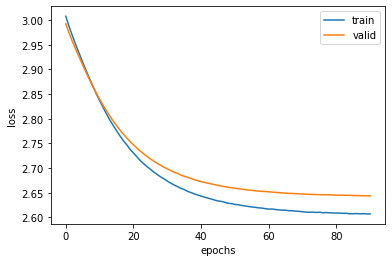

In [12]:
plt.plot(np.arange(len(history['train'])), history['train'], label='train')
plt.plot(np.arange(len(history['valid'])), history['valid'], label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [13]:
device="cpu"

model, optimizer, start_epoch = load_checkpoint(model, optimizer, epoch=history["best_epoch"])
model = model.to(device)
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, tt.Tensor):
            state[k] = v.to(device)

y_pred = predict(model, test_loader)
metrics.accuracy_score(y_test, y_pred)

=> loading checkpoint 'model/89'
=> loaded checkpoint 'model/89' (epoch 89)


0.7742963356346256

### What is the cross-entropy loss of uniformly random guessing classifier for this task? [0.5 point]

In [14]:
import random

r = [[random.uniform(0, 1) for i in range(len(np.unique(y_test)))]
     for j in range(len(y_test))]
torch.nn.functional.cross_entropy(torch.tensor(r), torch.tensor(y_test)).item()

3.0380773544311523

### What is the accuracy of constant prediction classifier for this task? [0.5 point]

In [15]:
acc = metrics.accuracy_score
metrices = [acc(y_test, [i] * y_test.shape[0]) for i in np.unique(y_test)]
np.mean(metrices)

0.05000000000000001